In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import offsetbox
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS, LocallyLinearEmbedding, Isomap
from sklearn.datasets import fetch_lfw_people, fetch_openml
from sklearn.decomposition import PCA
from matplotlib.image import imread

plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
# pca does not perform well when the data is not linearly separable
# manifold is a class of unsupervised estimators that seek to describe datasets as low-dimensional manifolds embedded in high-dimensional spaces(think of a sheet of paper as a 2D manifold embedded in our 3D world)
# we can rotate, reorient, and stretch the paper but it doesnt change its flat 2D nature such are akin to linear embeddings. if you bend curl or crumple the paper, it is still a 2D manifold but the embedding is no longer linear. these are akin to non-linear embeddings. maifold learning seeks to learn about the fundamental 2d nature of the paper even as it is contorted to fill the 3D space
# we can start making this more clear by generating a two dimensional data that we can use to define a manifold.
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis("off")
    ax.text(0.5, 0.4, "HELLO", va="center", ha="center", weight="bold", size=85)
    fig.savefig("hello.png")
    plt.close(fig)

    # Open this PNG and draw random points from it
    from matplotlib.image import imread

    data = imread("hello.png")[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = data[i, j] < 1
    X = X[mask]
    X[:, 0] *= data.shape[0] / data.shape[1]
    X = X[:N]
    return X[np.argsort(X[:, 0])]

/var/folders/8q/0wn9p2n54hb1x_gb6ckxsdxr0000gn/T/ipykernel_27535/2703128095.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))


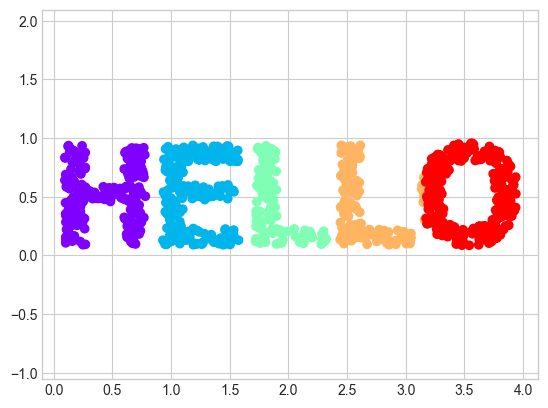

In [3]:
# lets call the function and visualize the data
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap("rainbow", 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis("equal")

Multidimensional scaling

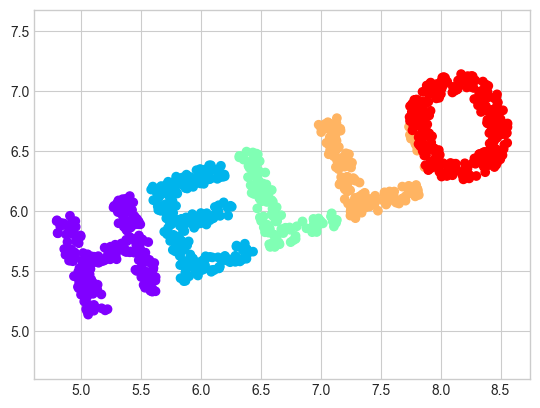

In [4]:
# looking at data like this, we can see that the particular choices of X and y values of the dataset are not the most fundamental description of the data: we can scale shrink or rotate the data, and the hello will still be apparent. for example, if we use a rotation matrix to rotate the data, the x and y values change, but the data is still fundamentally the same
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)


X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis("equal")

In [5]:
# this confirms that the x and y values are not necassarily fundamental to the relationships in the data. what is fundamental, in this case, is the distance between each point within the dataset. a common way to represent this is to use a distance matrix: for N points, we construct an N x N array such that entry i, j contains the distance between point i and point j. lets use scikit-learn's efficient pairwise_distances function to do this for our original data
D = pairwise_distances(X)
D.shape

(1000, 1000)

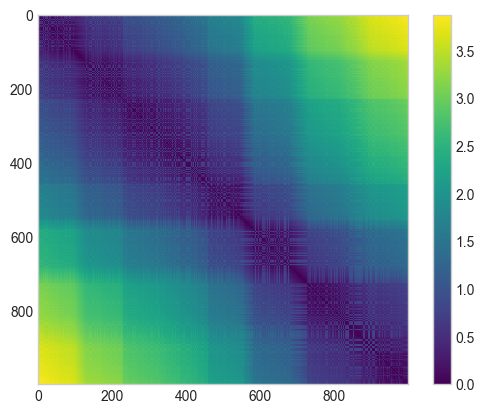

In [6]:
# for our N=1000 points, we obtain a 1000 x 1000 array
plt.imshow(D, zorder=2, cmap="viridis", interpolation="nearest")
plt.colorbar()

In [7]:
# if we construct a distance matrix for our rotated and translated data, we see that it is the same:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


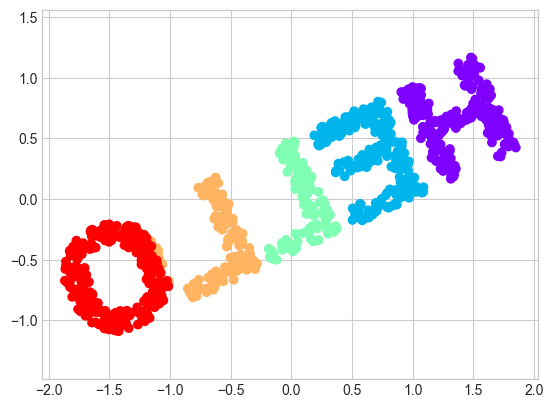

In [8]:
# this distance matrix gives us a representation of our data that is invariant to rotations and tranlations but the visulization of the matrix in the following figure is not entirely intuitive. In the representation shown there, we have lost any visible sign of the interesting structure in the data: the "HELLO" that we saw before.
# further when computing this distance matrix from the (X. y) coordinates is straightforward, transforming the distances back into x and y coordinates is rather difficult. this is exactly what the multidimensional scaling algorithm aims to do: given a distance matrix between points, it recovers a D-dimensional coordinate representation of the data. lets see how it works for our distance matrix, using the precomputed dissimilarity to specify that we are passing a distance matrix
model = MDS(n_components=2, dissimilarity="precomputed", random_state=1701)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis("equal")
# the MDS algo recovers one of the possible two dimensional coordinate representations of our data, using only the N x N distance matrix describing the relationship between the data points

MDS as manifold learning

In [9]:
# the usefulness of this becomes more apparent when we consider the fact that distance matrices can be computed from data in any dimension. so, for example, instead of simply rotating the data in the 2d plane, we can project this into a 3d plane as well.
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[: X.shape[1]])


X3 = random_projection(X, 3)
X3.shape

(1000, 3)

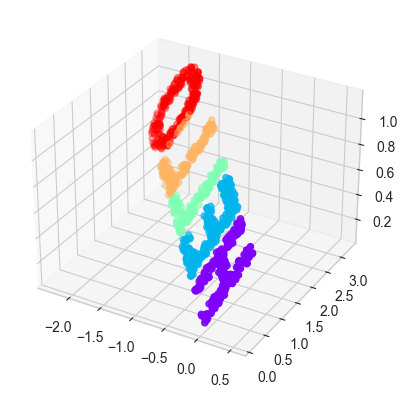

In [10]:
ax = plt.axes(projection="3d")
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2], **colorize)

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


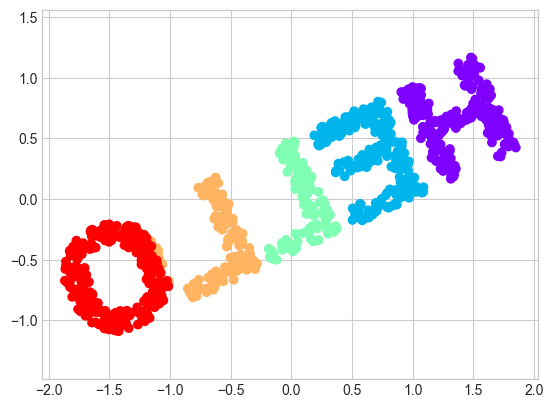

In [11]:
# we can now ask the mds estimator to input this three-dimensional data, compute the distace matrix and then determine the optimal two-dimensional embedding for this distance matrix. the result recovers a representation of the original data
model = MDS(n_components=2, random_state=1701)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis("equal")
# this is esentially the goal of manifold learnig: given high dimensional embedded data, it seeks a low dimensional representation of the data that preserves certain relationships within the data. in the case of MDS, the quantity preserved is the distance between every pair of points

Nonlinear embedding: where MDS fails

In [12]:
# the following embedding takes the input and contorts it into an s shape in three dimensions.
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T


XS = make_hello_s_curve(X)

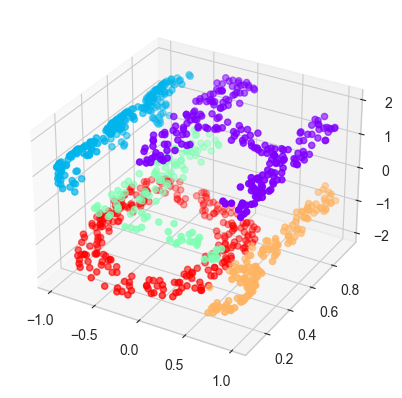

In [13]:
ax = plt.axes(projection="3d")
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize)

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


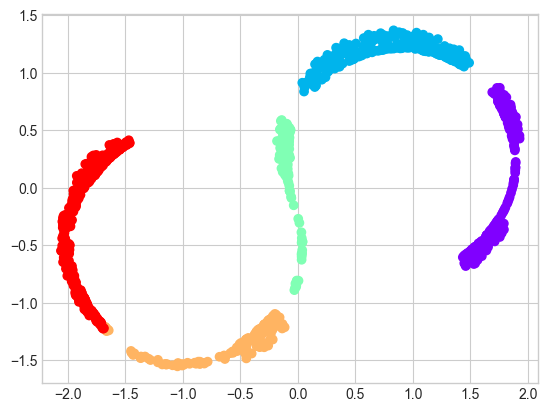

In [14]:
# the fundamental relationships between the data are still there but this time the data has been transformed in a nonlinear way. if we try to use MDS to recover a two-dimensional representation of this data, it is unable to untangle the data and we lose track of the fundamental relationships in the embedded manifold
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis("equal")

Nonlinear manifolds: Locally Linear Embedding

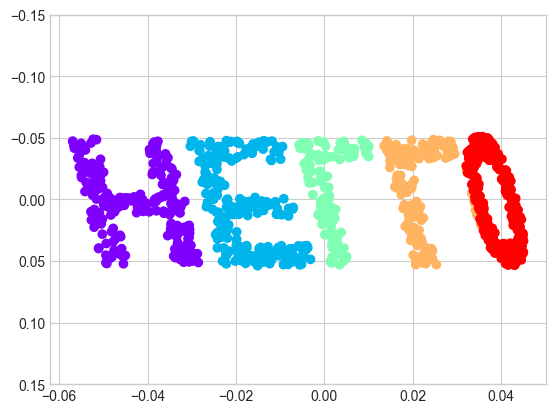

In [15]:
# locally linear embedding comes in a number of flavors; here we will use the modified LLE algorithm to recover the embedded two-dimensional manifold. in general, modified LLE does better than other flavors of the algorithm at recovering well-defined manifolds with very little distortion
model = LocallyLinearEmbedding(
    n_neighbors=100, n_components=2, method="modified", eigen_solver="dense"
)
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15)

In [16]:
# For high-dimensional data from real-world sources, LLE often produces poor results, and Isomap seems to generally lead to more meaningful embeddings. This is implemented in sklearn.manifold.Isomap.
# For data that is highly clustered, t-distributed stochastic neighbor embedding (t-SNE) seems to work very well, though it can be very slow compared to other methods. This is implemented in sklearn.manifold.TSNE.
# we can run isomap on the faces dataset
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(1985, 2914)

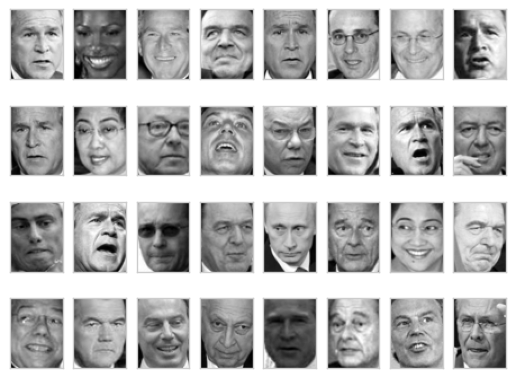

In [17]:
# lets plot a few of these faces to see what we're working with
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap="gray")

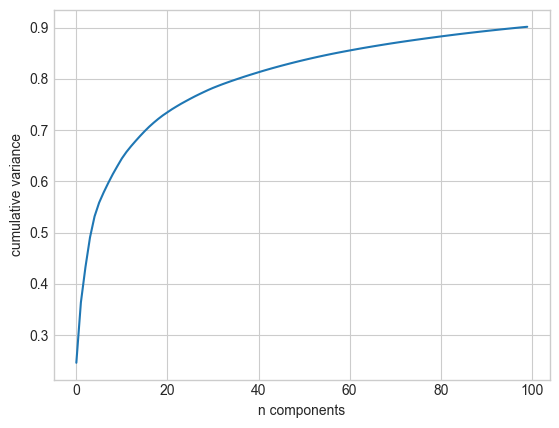

In [18]:
# we would like to plot a low-dimensional embedding of the 2914 dimensional data to learn the relationships
model = PCA(100, svd_solver="randomized").fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel("n components")
plt.ylabel("cumulative variance")

In [19]:
# we need about 100 components
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(1985, 2)

In [20]:
# the output is a two dimenstional projection of all the input images
# the following outputs thumbnails of the images at the locations corresponding to the projections
def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap="gray"):
    ax = ax or plt.gca()

    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], ".k")

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap), proj[i]
            )
            ax.add_artist(imagebox)

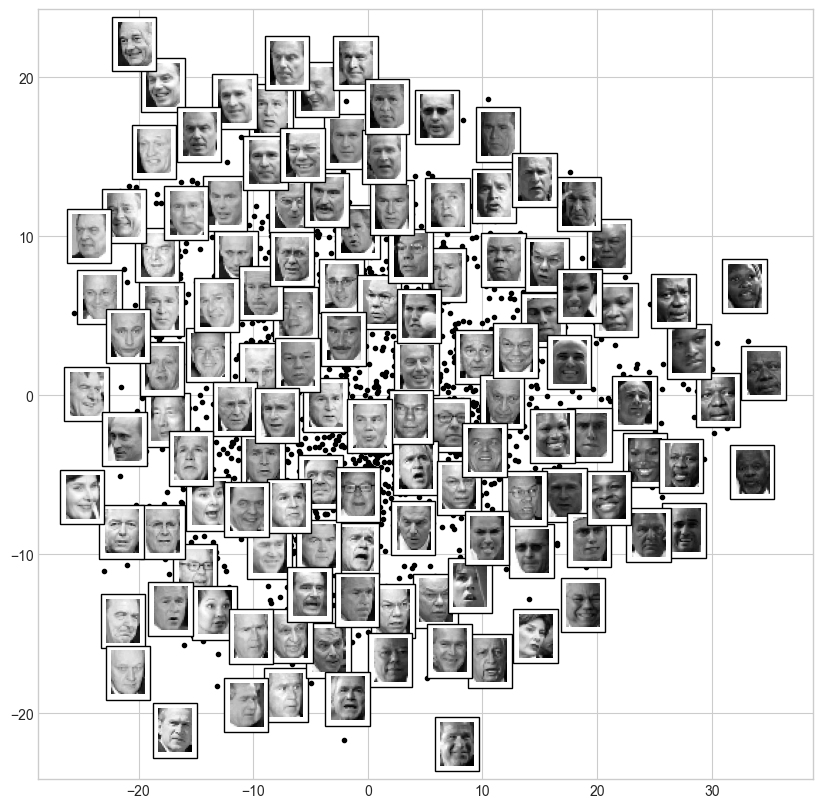

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(
    faces.data, model=Isomap(n_components=2), images=faces.images[:, ::2, ::2]
)

Visualizing Structure in Digits

In [22]:
# as another example let's take a look at the MNIST dataset. this is similar to the digits dataset we saw before, but with higher resolution images of handwritten digits
mnist = fetch_openml("mnist_784")
mnist.data.shape

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)

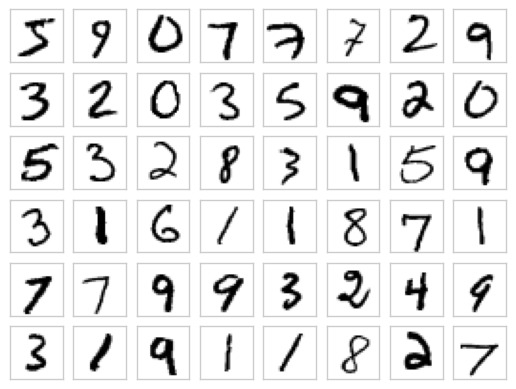

In [23]:
# the dataset consists of 70,000 images, each with 784 pixels (i.e. the images are 28×28) as before we can take a look at the first few images
mnist_data = np.asarray(mnist.data)
mnist_target = np.asarray(mnist.target, dtype=int)
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist_data[1250 * i].reshape(28, 28), cmap="gray_r")

/var/folders/8q/0wn9p2n54hb1x_gb6ckxsdxr0000gn/T/ipykernel_27535/478881427.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))


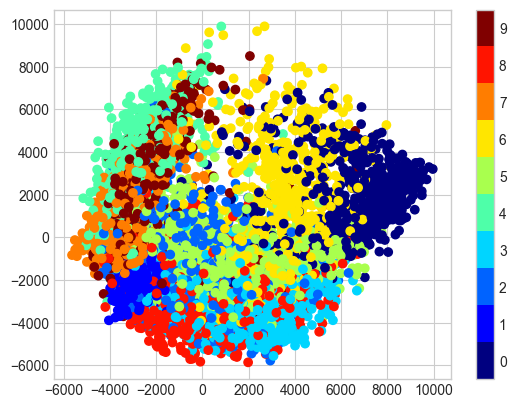

In [24]:
# we can compute a manifold learning projection across the data.
data = mnist_data[::10]
target = mnist_target[::10]

model = Isomap(n_components=2)
proj = model.fit_transform(data)

plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)

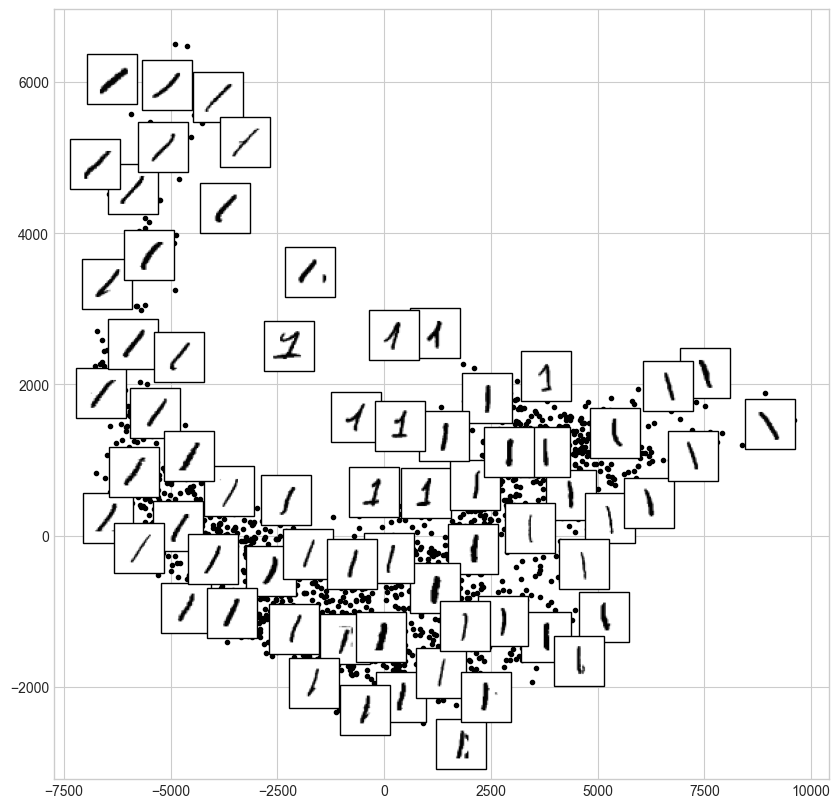

In [25]:
# we can gain more insight into the data by looking at just a single number at a time
data = mnist_data[mnist_target == 1][::4]
fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver="dense")
plot_components(
    data,
    model,
    images=data.reshape((-1, 28, 28)),
    ax=ax,
    thumb_frac=0.05,
    cmap="gray_r",
)
# the result gives you an idea of the variety of forms that the number "1" can take within the dataset the data lies along a broad curve in the projected space, which appears to trace the orientation of the digit. as you move up the plot, you find 1s that have hats and/or bases, though these are very sparse within the dataset the projection lets us identify outliers that have data issues. now this in itself may not be useful for the task of classifying digits, but it does help us get an understanding of the data, and may give us ideas about how to move forward, such as how we might want to preprocess the data before building a classification pipeline.